# Regression diagnostics:  testing the assumptions of linear regression

In [195]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip

## # Testing in both in and out of process

In [167]:
data = pd.read_csv('E:\singapore\data\preprocessed_data.csv')
data = data.drop(columns=['Unnamed: 0'], axis=1)
data_copy = data.copy()
data.head(1)

,month,flat_type,storey_range,resale_price,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special,model_Standard,floor_area_sqm,lease_commence_date,remaining_lease,lat,long,distanceWithMrt,distanceWithRaffles,distanceWithGdPri
0,2018-01,0,3,250000.0,0,0,0,0,0,1,-2.190579,-1.237792,-1.168075,-0.115848,0.157471,-0.860465,-0.872183,0.730986


### * check whether model existed or not (significance relationship between the independent variables and the dependent variable)

In [20]:
#using F-statictics, this first test, it just check whether the model with current features exist or not, after few next steps,
#i will test it again.

In [168]:
data['resale_price'] = np.log(data['resale_price'])

In [169]:
Y = data['resale_price']
X = data[['flat_type', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'lat', 'long'
          , 'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri',
          'model_Apartment', 'model_Maisonette', 'model_Model A', 'model_New Generation', 'model_Special', 'model_Standard']]

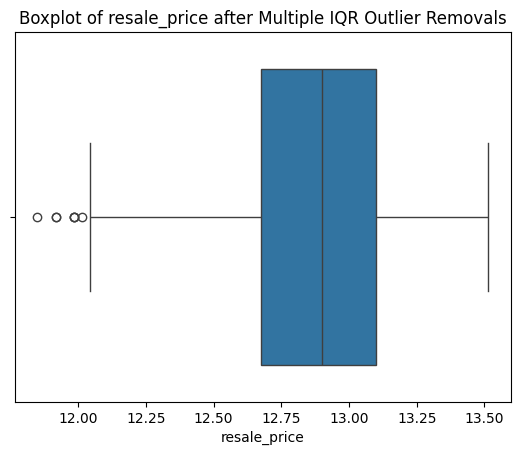

In [170]:
sns.boxplot(x=data['resale_price'])
plt.title('Boxplot of resale_price after Multiple IQR Outlier Removals')
plt.show()

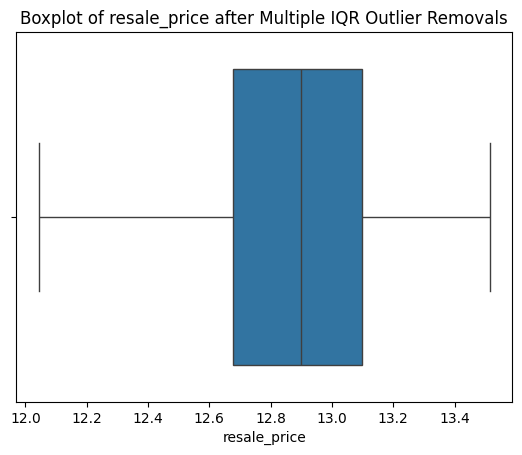

In [171]:
for iteration in range(4):
    Q1 = data['resale_price'].quantile(0.25)
    Q3 = data['resale_price'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['resale_price'] < lower_bound) | (data['resale_price'] > upper_bound)]

    data = data[(data['resale_price'] >= lower_bound) & (data['resale_price'] <= upper_bound)]
    if outliers.empty:
        break

# Visualize the distribution after multiple outlier removals
sns.boxplot(x=data['resale_price'])
plt.title('Boxplot of resale_price after Multiple IQR Outlier Removals')
plt.show()

In [172]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 2.164e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:36:21   Log-Likelihood:                 41942.
No. Observations:               54303   AIC:                        -8.385e+04
Df Residuals:                   54287   BIC:                        -8.371e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.9449      0.004   2846.037      0.000      10.937      10.952
flat_type                0.0521      0.002     25.448      0.000       0.048       0.056
storey_range             0.0266      0.000     88.306      0.000       0.026       0.027
floor_area_sqm           0.1967      0.002    110.439      0.000       0.193       0.200
lease_commence_date      0.0647      0.008      8.222      0.000       0.049       0.080
remaining_lease          0.0641      0.008      8.128      0.000       0.049       0.079
lat                     -0.0423      0.001    -51.965      0.000      -0.044      -0.041
long                     0.0180      0.001     31.283      0.000       0.017       0.019
distanceWithMrt         -0.0509      0.000   -102.049      0.000      -0.052      -0.050
distanceWithRaffles     -0.1110      0.001   -122.685      0.000      -0.113      -0.109
distanceWithGdPri       -0.0056      0.000    -11.373      0.000      -0.007      -0.005
model_Apartment          1.7683      0.002   1071.855      0.000       1.765       1.772
model_Maisonette         1.7876      0.003    592.435      0.000       1.782       1.794
model_Model A            1.7891      0.001   1537.126      0.000       1.787       1.791
model_New Generation     1.8131      0.002   1076.732      0.000       1.810       1.816
model_Special            2.0333      0.004    479.288      0.000       2.025       2.042
model_Standard           1.7536      0.001   1180.856      0.000       1.751       1.757
==============================================================================
Omnibus:                     3524.196   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7475.634
Skew:                           0.439   Prob(JB):                         0.00
Kurtosis:                       4.591   Cond. No.                     3.72e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.57e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
# vì Prob (F-statistic) = 0.00 < 5% nên model tồn tại. Hay nói cách khác với mức ý nghĩa 5% có thể kết luận 
# có ít nhất 1 trong 10 biến X có tác động đến Y

In [173]:
#multicolinearlity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(data.drop('resale_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,15.295813,0.065377,41.63023
1,storey_range,1.120351,0.892577,41.63023
2,model_Apartment,14.222016,0.070314,41.63023
3,model_Maisonette,3.617636,0.276424,41.63023
4,model_Model A,28.368177,0.035251,41.63023
5,model_New Generation,12.520080,0.079872,41.63023
6,model_Special,1.788606,0.559095,41.63023
7,model_Standard,26.810851,0.037298,41.63023
8,floor_area_sqm,13.773516,0.072603,41.63023
9,lease_commence_date,268.798002,0.003720,41.63023


In [174]:
#in this case, i supposed to eliminate with highest VIF, but i think those still be important for the model, so i intend to 
#remove other features (also with high VIF which is larger than 10)

#especially, im gonna to eliminate model_Model A and model_Standard (28 and 26)
data = data.drop(columns=['remaining_lease'], axis =1)

In [175]:
# rerun
calc_vif(data.drop('resale_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,15.287638,0.065412,8.635524
1,storey_range,1.119498,0.893258,8.635524
2,model_Apartment,14.214653,0.070350,8.635524
3,model_Maisonette,3.613200,0.276763,8.635524
4,model_Model A,28.358079,0.035263,8.635524
5,model_New Generation,12.511287,0.079928,8.635524
6,model_Special,1.787191,0.559537,8.635524
7,model_Standard,26.778000,0.037344,8.635524
8,floor_area_sqm,13.773465,0.072603,8.635524
9,lease_commence_date,2.080331,0.480693,8.635524


In [176]:
data = data.drop(columns=['model_Model A'], axis =1)

In [177]:
calc_vif(data.drop('resale_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,flat_type,5.750436,0.173900,2.188298
1,storey_range,2.758900,0.362463,2.188298
2,model_Apartment,1.674087,0.597340,2.188298
3,model_Maisonette,1.351031,0.740175,2.188298
4,model_New Generation,1.834772,0.545027,2.188298
5,model_Special,1.040658,0.960930,2.188298
6,model_Standard,2.301901,0.434424,2.188298
7,floor_area_sqm,2.027146,0.493304,2.188298
8,lease_commence_date,1.941609,0.515037,2.188298
9,lat,2.867303,0.348760,2.188298


In [178]:
Y = data['resale_price']
X = data[['flat_type', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'lat', 'long'
          , 'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri','model_Apartment','model_Maisonette',
          'model_New Generation','model_Special', 'model_Standard']]

In [179]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 2.317e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:38:16   Log-Likelihood:                 41956.
No. Observations:               54296   AIC:                        -8.388e+04
Df Residuals:                   54281   BIC:                        -8.375e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.7339      0.004   3149.022      0.000      12.726      12.742
flat_type                0.0522      0.002     25.526      0.000       0.048       0.056
storey_range             0.0267      0.000     88.574      0.000       0.026       0.027
floor_area_sqm           0.1967      0.002    110.498      0.000       0.193       0.200
lease_commence_date      0.1283      0.001    185.465      0.000       0.127       0.130
lat                     -0.0423      0.001    -51.989      0.000      -0.044      -0.041
long                     0.0180      0.001     31.276      0.000       0.017       0.019
distanceWithMrt         -0.0509      0.000   -102.149      0.000      -0.052      -0.050
distanceWithRaffles     -0.1109      0.001   -122.669      0.000      -0.113      -0.109
distanceWithGdPri       -0.0057      0.000    -11.584      0.000      -0.007      -0.005
model_Apartment         -0.0209      0.002    -12.462      0.000      -0.024      -0.018
model_Maisonette        -0.0021      0.003     -0.617      0.537      -0.009       0.005
model_New Generation     0.0234      0.002     13.610      0.000       0.020       0.027
model_Special            0.2434      0.005     49.559      0.000       0.234       0.253
model_Standard          -0.0359      0.001    -24.585      0.000      -0.039      -0.033
==============================================================================
Omnibus:                     3516.571   Durbin-Watson:                   0.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7318.310
Skew:                           0.444   Prob(JB):                         0.00
Kurtosis:                       4.564   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**fit model**

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # square root of MSE

# Print evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.012622729177627266
Root Mean Squared Error (RMSE): 0.11235091978985871


In [121]:
# train_start_date = '2018-01'
# test_start_date = '2020-01'

# train = data[data['month'] < test_start_date]
# test = data[data['month'] >= test_start_date]

In [122]:
# train = train.drop('month', axis= 1)
# test = test.drop('month', axis= 1)

In [123]:
# X_train = train.drop('resale_price', axis=1)
# Y_train = train['resale_price']
# X_test = test.drop('resale_price', axis=1)
# Y_test = test['resale_price']

In [182]:
# phần dư có phân phối chuẩn
model = sm.OLS(y_train, X_train).fit()

# Get the residuals
residuals = model.resid

In [185]:
jb_statistic = sm.stats.jarque_bera(residuals)

# Extract the Jarque-Bera statistic and its associated p-value
jb_test_statistic = jb_statistic[0]
jb_p_value = jb_statistic[1]

# Display the Jarque-Bera statistic and its p-value
print(f"Jarque-Bera Statistic for Residuals: {jb_test_statistic}")
print(f"P-Value for Residuals: {jb_p_value}")

# Check the significance level (commonly 0.05)
alpha = 0.05

# Compare the Jarque-Bera statistic to the critical value
if jb_p_value < alpha:
    print("Reject the null hypothesis: Residuals are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Residuals follow a normal distribution.")

Jarque-Bera Statistic for Residuals: 6253.711946388389
P-Value for Residuals: 0.0
Reject the null hypothesis: Residuals are not normally distributed.


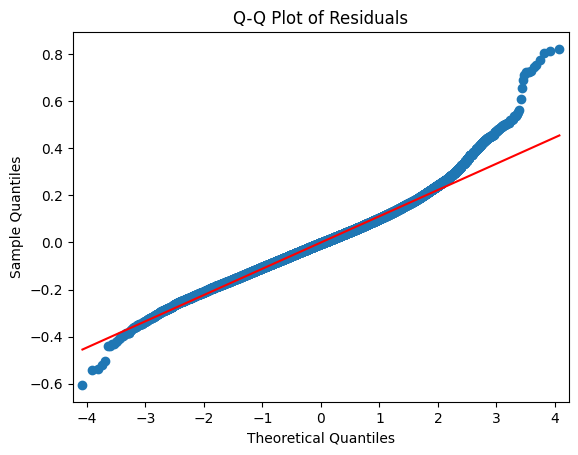

In [186]:
sm.qqplot(residuals, line='s')  # 's' for standard normal distribution line
plt.title('Q-Q Plot of Residuals')
plt.show()

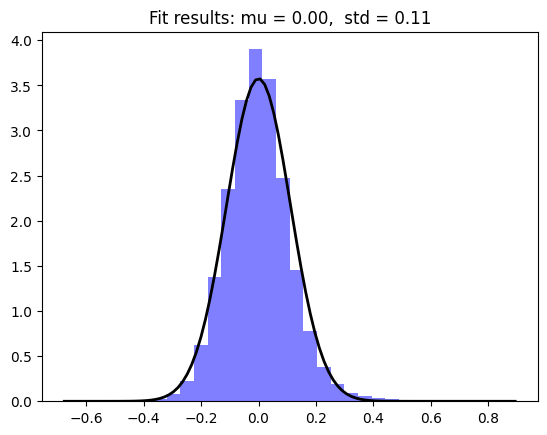

In [187]:
# Plot a histogram of residuals
plt.hist(residuals, bins=30, density=True, alpha=0.5, color='b')

# Fit a normal distribution to the data
mu, sigma = stats.norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)

plt.show()

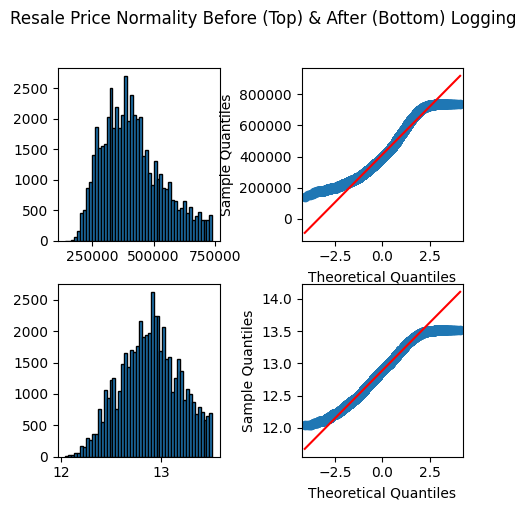

In [189]:
# do biểu đồ phân phối của resale_price lệch sang trái nên dùng log transformation để đưa về dạng pp chuẩn
# plot qqplot before and after log transformation => nên đưa vào model giá trị log của y

from statsmodels.api import qqplot
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(5,5))

ax1.hist(data_copy['resale_price'], bins=50, edgecolor='black')
qqplot(data_copy['resale_price'], line='s', ax=ax2)
ax3.hist(data['resale_price'], bins=50, edgecolor='black')
qqplot(data['resale_price'], line='s', ax=ax4)
plt.suptitle('Resale Price Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

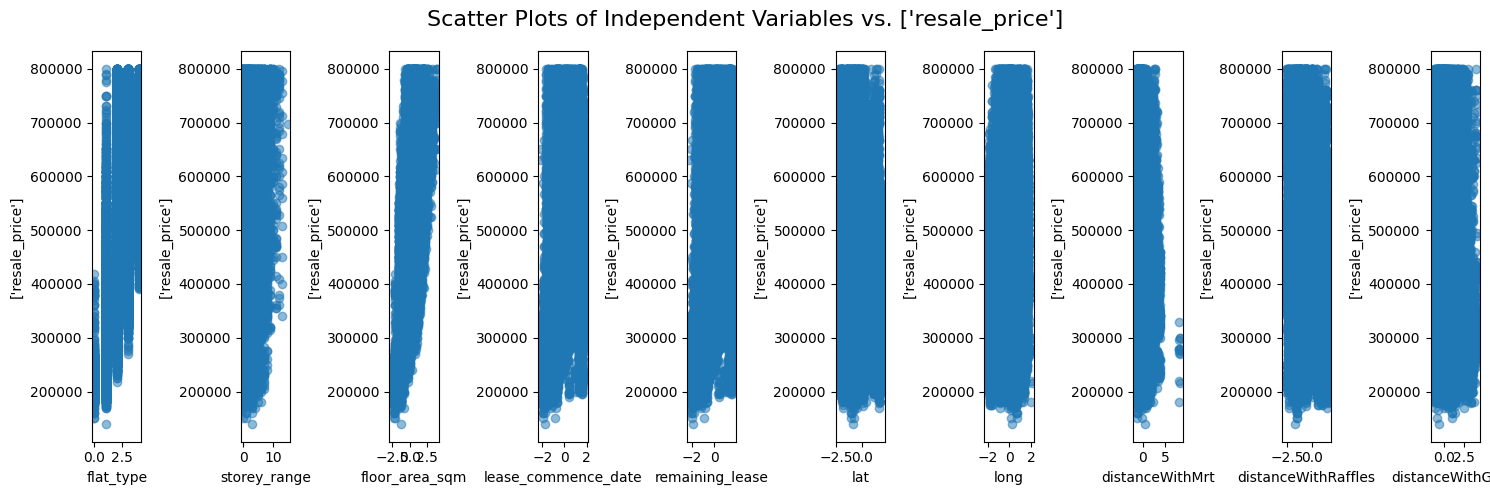

In [35]:
independent_vars = ['flat_type', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'lat', 'long'
          , 'distanceWithMrt', 'distanceWithRaffles', 'distanceWithGdPri']
dependent_var = ['resale_price']

num_subplots = len(independent_vars)
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# Loop through the independent variables and create scatter plots
for i, var in enumerate(independent_vars):
    axes[i].scatter(data[var], data[dependent_var], alpha=0.5)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(dependent_var)

# Set a common title for all subplots
fig.suptitle(f'Scatter Plots of Independent Variables vs. {dependent_var}', fontsize=16)

plt.tight_layout()
plt.show()

In [190]:
# kỳ vọng toán ( trung bình ) của phần dư
# Calculate the mean and standard error of the residuals
mean_residual = residuals.mean()
se_residual = stats.sem(residuals)
print(mean_residual)

# Define the null hypothesis and the test statistic
null_hypothesis = 0  # The null hypothesis is that the mean of the residuals is zero
t_statistic = (mean_residual - null_hypothesis) / se_residual

# Define the significance level (commonly 0.05)
alpha = 0.05

# Perform the one-sample t-test
t_critical = stats.t.ppf(1 - alpha / 2, df=len(residuals) - 1)  # Calculate the critical t-value

p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=len(residuals) - 1))

# Compare the test statistic to the critical t-value
if abs(t_statistic) > t_critical:
    print(f"Reject the null hypothesis: Mean of residuals is significantly different from {null_hypothesis}.")
else:
    print(f"Fail to reject the null hypothesis: Mean of residuals is not significantly different from {null_hypothesis}.")

# Display the p-value
print(f"P-Value: {p_value}")

4.193741464850394e-14
Fail to reject the null hypothesis: Mean of residuals is not significantly different from 0.
P-Value: 0.9999999999374998


In [191]:
# Mô hình bằng không tồn tại hiện tượng Tự tương quan
dw_statistic = durbin_watson(residuals)

# Display the Durbin-Watson statistic
print(f"Durbin-Watson Statistic: {dw_statistic}")

# Interpret the Durbin-Watson statistic
# Rule of thumb: If the statistic is close to 2, there is no significant autocorrelation. 
# Values significantly less than 2 suggest positive autocorrelation, while values significantly greater than 2 suggest negative autocorrelation.
if dw_statistic < 1.5:
    print("Positive autocorrelation may be present.")
elif dw_statistic > 2.5:
    print("Negative autocorrelation may be present.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson Statistic: 2.0047933355817453
No significant autocorrelation detected.


In [202]:
import statsmodels.stats.api as sms
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

#Since p value is more than 0.05 in Goldfeld Quandt Test, we can't reject it's null hypothesis that 
# error terms are homoscedastic. Good

[('F statistic', 0.9918684848240563), ('p-value', 0.7262150839613897)]

In [77]:
# from sklearn.linear_model import LinearRegression

# # sklearn method, which doesn't give much additional info

# lin_reg = LinearRegression()
# lin_reg.fit(X, np.log(Y))

# print(f'Coefficients: {lin_reg.coef_}')
# print(f'Intercept: {lin_reg.intercept_}')
# print(f'R^2 score: {lin_reg.score(X, np.log(Y))}')

Coefficients: [ 0.          0.02726317  0.0267505   0.21667498  0.06645042  0.06829336
 -0.0431565   0.0172349  -0.05318219 -0.11678411 -0.00473865]
Intercept: 12.7907690142251
R^2 score: 0.8525492770137946
